# WEEK 8 HW style transfer

In [4]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.11.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  True
Metal device set to: Apple M1 Pro


2023-03-12 21:38:04.622861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 21:38:04.622923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# @title Define image loading and visualization functions  { display-mode: "form" }


def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape # retrieves the shape of the input image using image.shape.
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

In [43]:
# @title To Run: Load more images { display-mode: "form" }

content_urls = dict(
  Audrey_hepburn='https://upload.wikimedia.org/wikipedia/commons/5/5e/Audrey_Hepburn_1956.jpg',
  sun_flower = 'https://upload.wikimedia.org/wikipedia/commons/4/40/Sunflower_sky_backdrop.jpg',
  
)
style_urls = dict(
  ab_stract='https://upload.wikimedia.org/wikipedia/commons/f/fc/DasUndbild.jpg',
  ab_atract2='https://upload.wikimedia.org/wikipedia/commons/6/63/Robert_Delaunay%2C_1913%2C_Premier_Disque%2C_134_cm%2C_52.7_inches%2C_Private_collection.jpg',
  ab_stract3 = 'https://upload.wikimedia.org/wikipedia/en/b/b7/Pablo_Picasso%2C_1913-14%2C_Head_%28T%C3%AAte%29%2C_cut_and_pasted_colored_paper%2C_gouache_and_charcoal_on_paperboard%2C_43.5_x_33_cm%2C_Scottish_National_Gallery_of_Modern_Art%2C_Edinburgh.jpg',
  chi_painting = 'https://upload.wikimedia.org/wikipedia/commons/4/43/Wang_Ximeng_-_A_Thousand_Li_of_River_%28Bridge%29.jpg',
  chi_painting2 = 'https://upload.wikimedia.org/wikipedia/commons/4/4b/Making_farewells_at_Jingkou.jpg',
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}

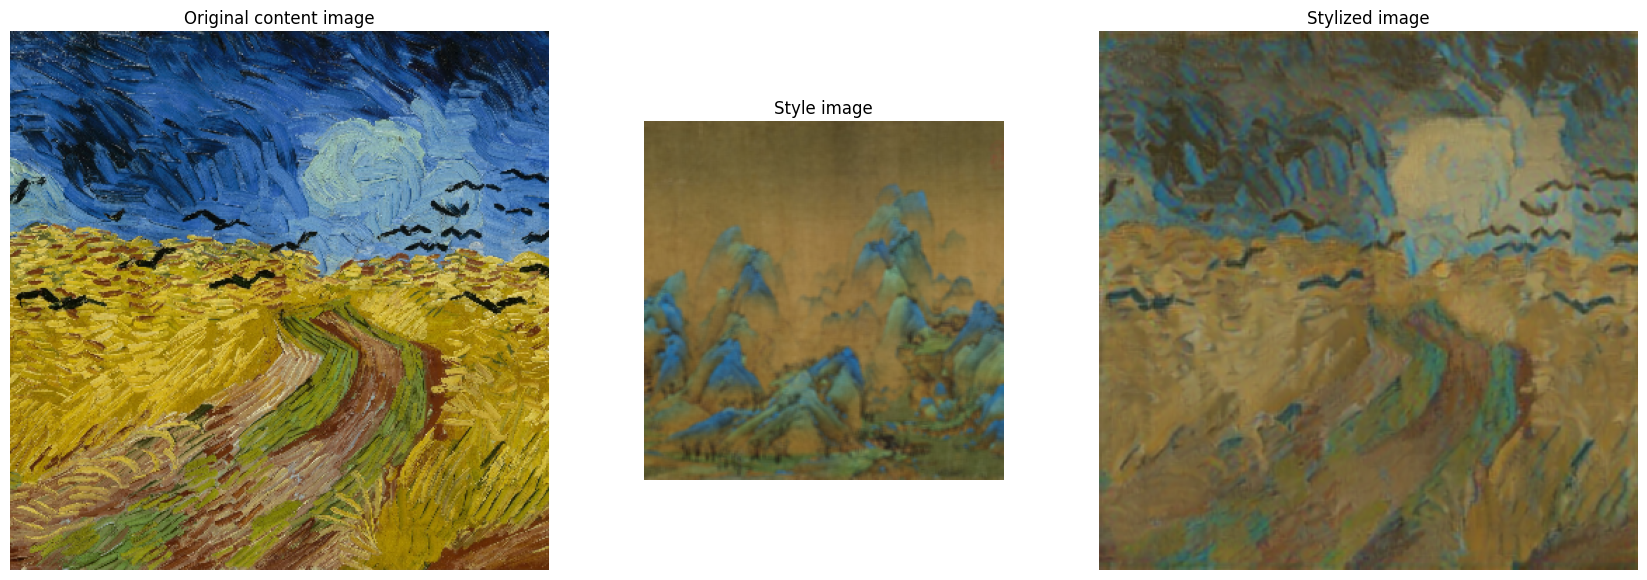

In [45]:
#@title Specify the main content image and the style you want to use.  { display-mode: "form" }

content_name = 'van_gough'  
style_name = 'chi_painting'  
stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

23161526/23161526 [==============================] - 1s 0us/step


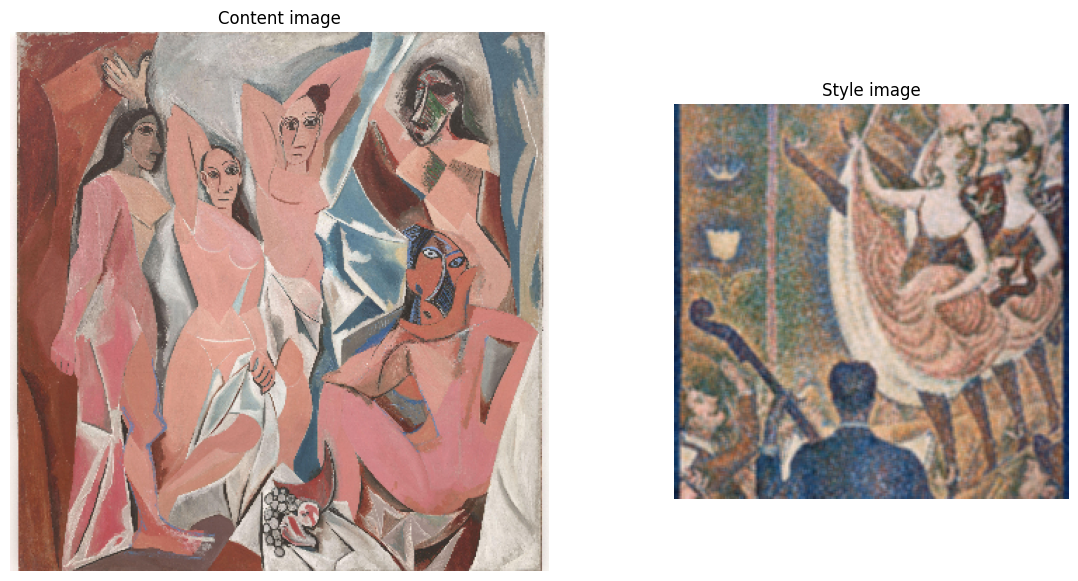

In [46]:
# Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/c/c2/Georges_Seurat%2C_1889-90%2C_Le_Chahut%2C_Kr%C3%B6ller-M%C3%BCller_Museum.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [47]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [48]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

2023-03-13 10:40:30.622987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


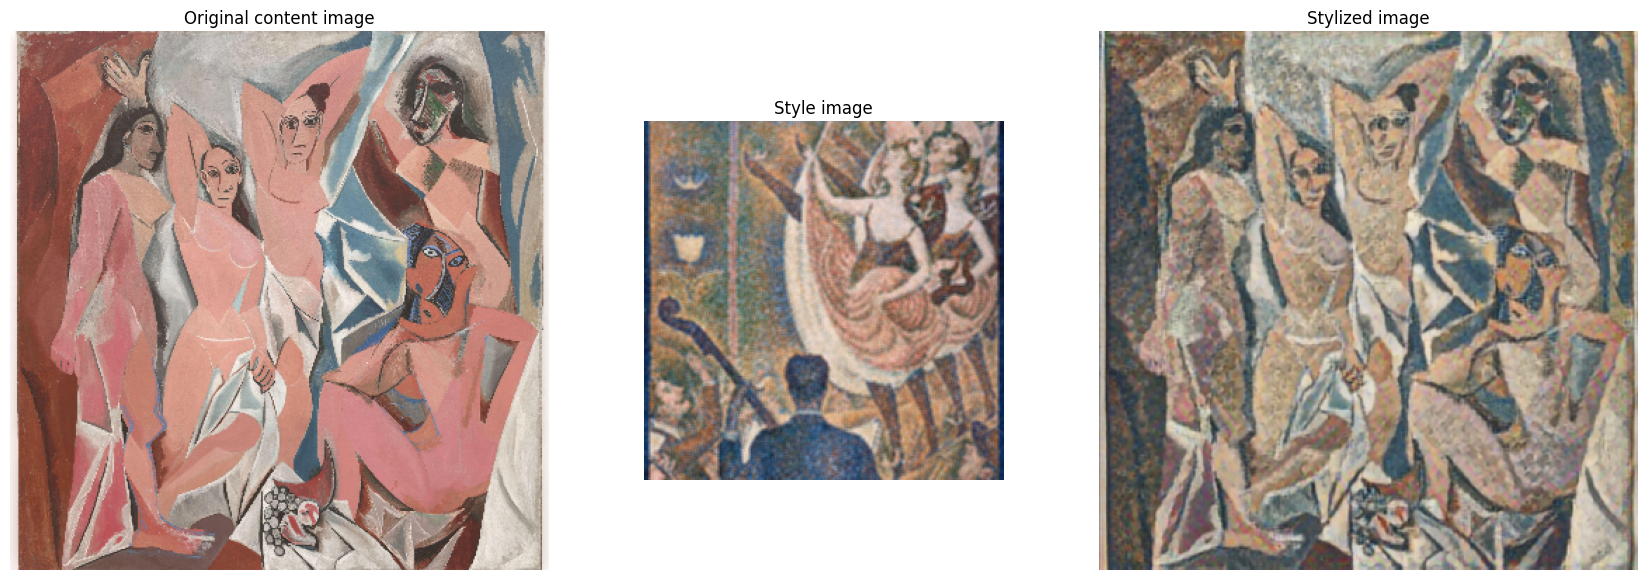

In [49]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

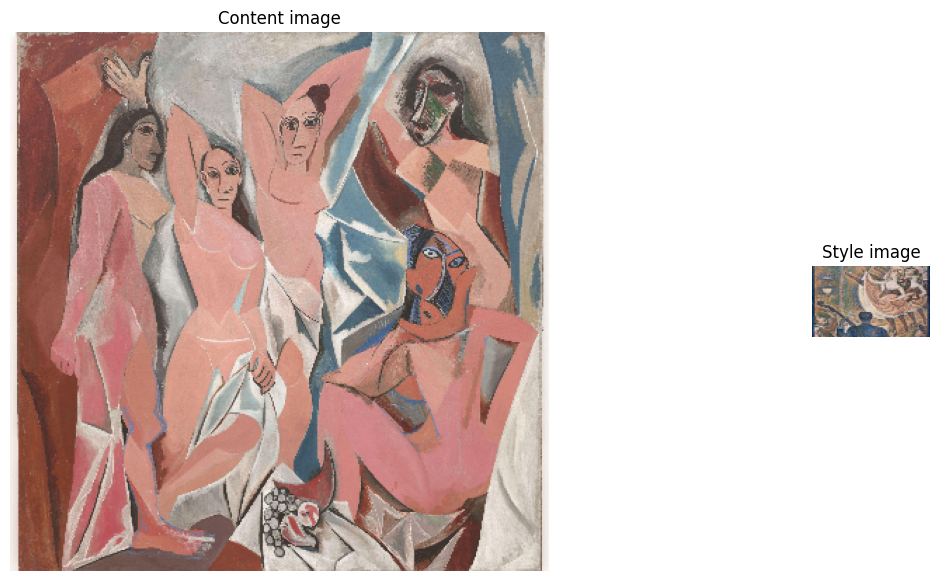

In [24]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/c/c2/Georges_Seurat%2C_1889-90%2C_Le_Chahut%2C_Kr%C3%B6ller-M%C3%BCller_Museum.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[5,3], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [25]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [26]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

2023-03-14 21:31:06.518486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


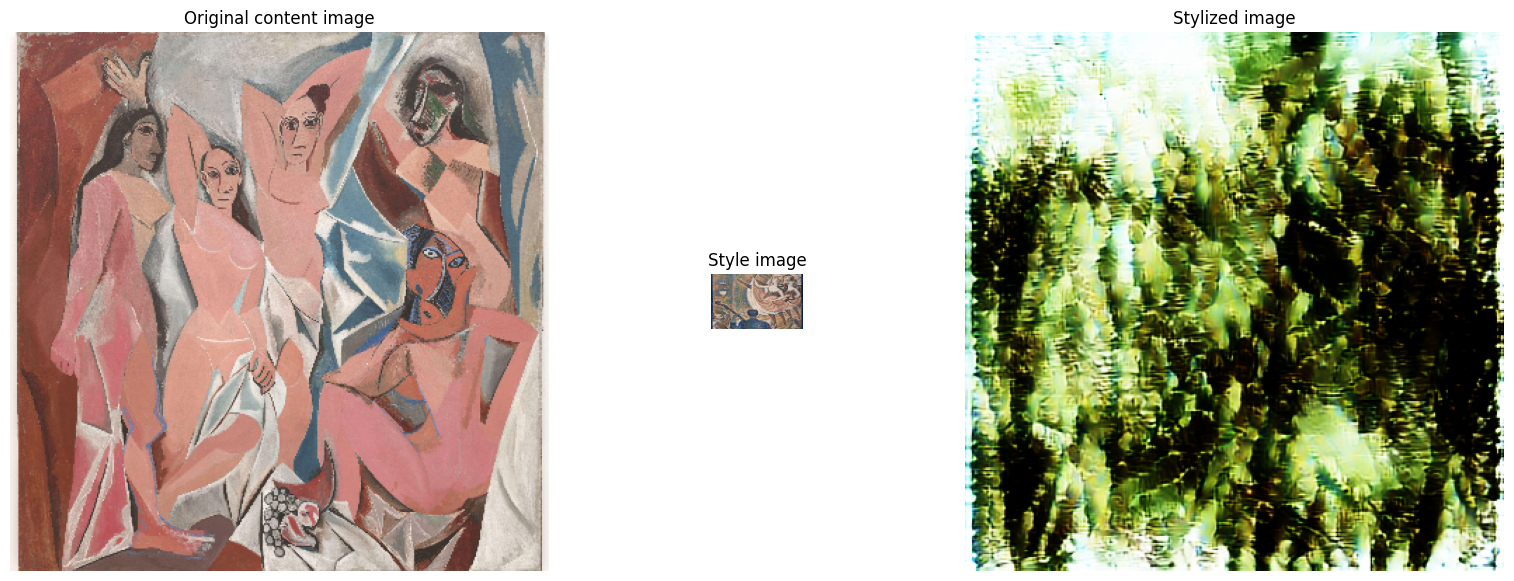

In [27]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])
